# **🏠 Airbnb Price Prediction**

## Introduction
Ce projet a pour objectif de prédire le logarithme du prix d'une location Airbnb (log_price) à partir des caractéristiques des annonces. Le travail est divisé en deux grandes phases :

- Exploration des données (EDA) pour comprendre la structure et la qualité des données

- Modélisation supervisée pour prédire les prix à partir des variables pertinentes

## Chargement des données

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Lecture des fichiers CSV
df_train = pd.read_csv("airbnb_train.csv", quoting=1, on_bad_lines='skip', engine="python")
df_test = pd.read_csv("airbnb_test.csv", quoting=1, on_bad_lines='skip', engine="python")

# Correction du nom de colonne dans le test
df_test = df_test.rename(columns={"Unnamed: 0": "id"})


 ## Exploration des données
Objectif : Comprendre les variables disponibles, leur distribution, les valeurs manquantes, et les corrélations.
- **Aperçu du dataset**

In [25]:
df_train.info()
df_train.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
count,2.223400e+04,22234.000000,22234,22234,22234,22234.000000,22183.000000,22234,22234,22234,...,17518,22234.000000,22234.000000,22234,20148,22234.000000,17256.000000,21931,22208.000000,22199.000000
unique,NaN,NaN,31,3,21160,NaN,NaN,5,5,2,...,1042,NaN,NaN,22155,558,NaN,NaN,674,NaN,NaN
top,NaN,NaN,Apartment,Entire home/apt,{},NaN,NaN,Real Bed,strict,True,...,2017-04-30,NaN,NaN,East Village Studio,Williamsburg,NaN,NaN,11211.0,NaN,NaN
freq,NaN,NaN,14635,12348,161,NaN,NaN,21622,9726,16401,...,420,NaN,NaN,4,878,NaN,NaN,425,NaN,NaN
mean,1.122269e+07,4.783481,NaN,NaN,NaN,3.155573,1.236037,NaN,NaN,NaN,...,NaN,38.462971,-92.269305,NaN,NaN,20.670774,94.069077,NaN,1.264769,1.711473
std,6.080480e+06,0.718758,NaN,NaN,NaN,2.143870,0.586246,NaN,NaN,NaN,...,NaN,3.071679,21.670081,NaN,NaN,37.183731,7.782235,NaN,0.852819,1.254903
min,3.362000e+03,2.302585,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,...,NaN,33.339002,-122.510940,NaN,NaN,0.000000,20.000000,NaN,0.000000,0.000000
25%,6.202924e+06,4.317488,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,...,NaN,34.136082,-118.340633,NaN,NaN,1.000000,92.000000,NaN,1.000000,1.000000
50%,1.217425e+07,4.700480,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,...,NaN,40.662632,-76.994944,NaN,NaN,6.000000,96.000000,NaN,1.000000,1.000000
75%,1.639502e+07,5.220356,NaN,NaN,NaN,4.000000,1.000000,NaN,NaN,NaN,...,NaN,40.746358,-73.954599,NaN,NaN,23.000000,100.000000,NaN,1.000000,2.000000


- **Distribution de la variable cible log_price**

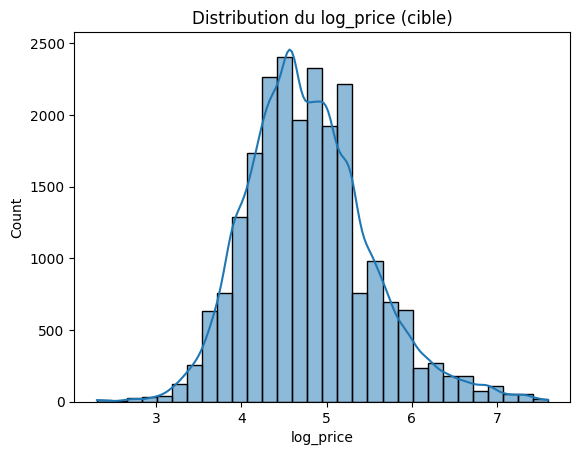

In [26]:
sns.histplot(df_train["log_price"], kde=True, bins=30)
plt.title("Distribution du log_price (cible)")
plt.xlabel("log_price")
plt.show()

- **Répartition du nombre de chambres (bedrooms)**

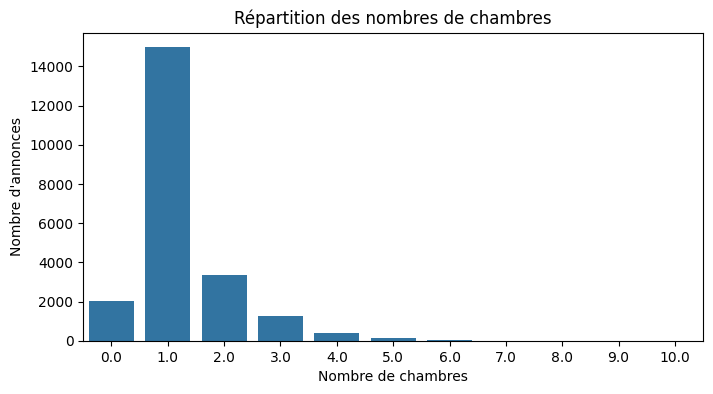

In [44]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x="bedrooms")
plt.title("Répartition des nombres de chambres")
plt.xlabel("Nombre de chambres")
plt.ylabel("Nombre d'annonces")
plt.show()

- **Corrélation entre les variables numériques**

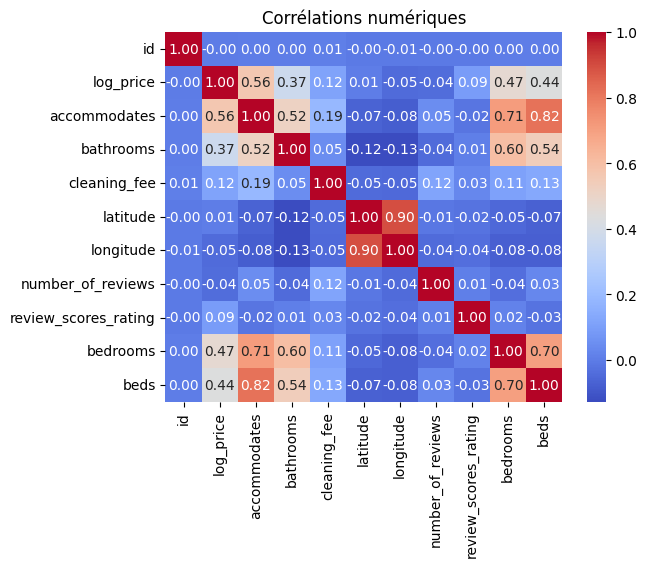

In [27]:
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations numériques")
plt.show()

- **Carte géographique des annonces (lat/lon)**

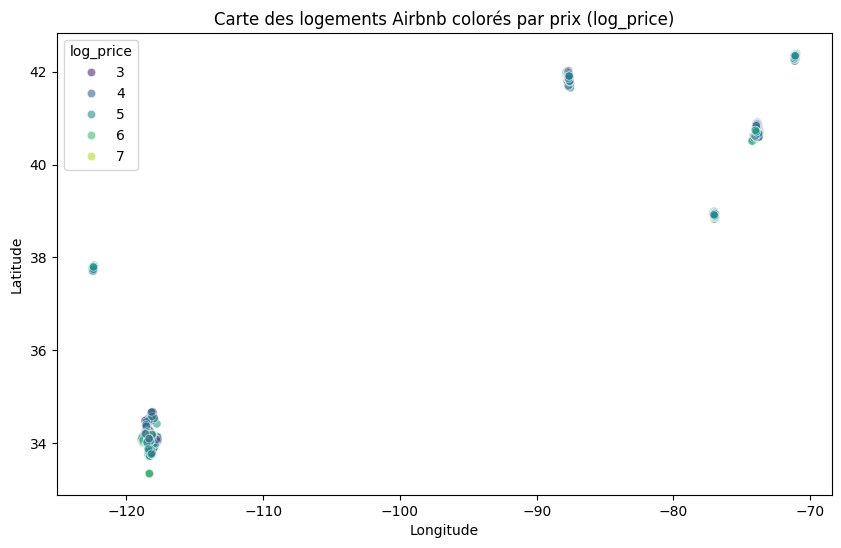

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x="longitude", y="latitude", hue="log_price", palette="viridis", alpha=0.6)
plt.title("Carte des logements Airbnb colorés par prix (log_price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="log_price")
plt.show()

## Préparation des données
Objectif : Nettoyer les données et préparer les variables pour les modèles de ML
- **Suppression des colonnes inutiles (textes longs et dates)**

In [28]:
target = "log_price"
drop_cols = ["log_price", "description", "name", "first_review", "last_review", "host_since", "amenities"]
features = [col for col in df_train.columns if col not in drop_cols + ["id"]]

X = df_train[features]
y = df_train[target]
X_test = df_test[features]

- **Conversion des booléens en 0/1**


In [29]:
bool_cols = ["cleaning_fee", "host_has_profile_pic", "host_identity_verified", "instant_bookable"]
for col in bool_cols:
    X[col] = X[col].astype(str).map({"t": 1, "f": 0, "True": 1, "False": 0})
    X_test[col] = X_test[col].astype(str).map({"t": 1, "f": 0, "True": 1, "False": 0})

C:\Users\abygu\AppData\Local\Temp\ipykernel_16292\24961723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str).map({"t": 1, "f": 0, "True": 1, "False": 0})
C:\Users\abygu\AppData\Local\Temp\ipykernel_16292\24961723.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype(str).map({"t": 1, "f": 0, "True": 1, "False": 0})
C:\Users\abygu\AppData\Local\Temp\ipykernel_16292\24961723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

- **Conversion du taux de réponse (ex: "90%") en float**

In [30]:
X["host_response_rate"] = X["host_response_rate"].str.replace("%", "").astype(float)
X_test["host_response_rate"] = X_test["host_response_rate"].str.replace("%", "").astype(float)

C:\Users\abygu\AppData\Local\Temp\ipykernel_16292\4276381924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["host_response_rate"] = X["host_response_rate"].str.replace("%", "").astype(float)
C:\Users\abygu\AppData\Local\Temp\ipykernel_16292\4276381924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["host_response_rate"] = X_test["host_response_rate"].str.replace("%", "").astype(float)


 ## Pipeline de transformation et Modélisation
Objectif : Créer un pipeline Scikit-learn pour traiter les colonnes numériques et catégorielles
- **Séparation des colonnes numériques et catégorielles**

In [31]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

 - **Boxplot du prix par type de chambre (room_type)**

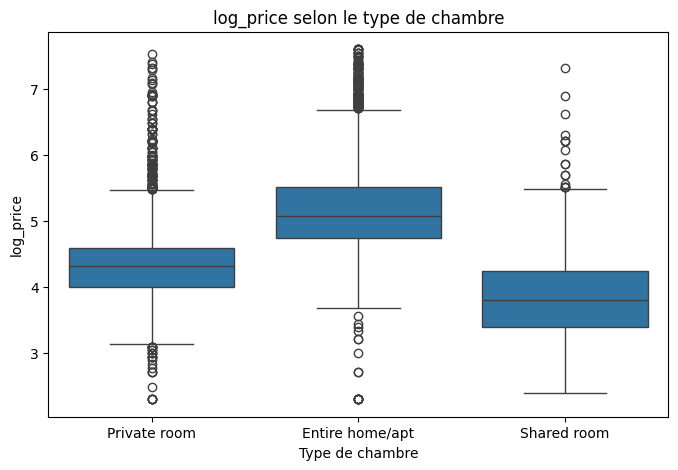

In [47]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_train, x="room_type", y="log_price")
plt.title("log_price selon le type de chambre")
plt.xlabel("Type de chambre")
plt.ylabel("log_price")
plt.show()

- **Création du pipeline de preprocessing**

In [32]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

- **Ajout du modèle Random Forest**

In [33]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'cleaning_fee',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'host_response_rate',
                                                   'instant_bookable',
                                                   'latitude', 'longitude',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'bedrooms', 'beds']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'bed_type',
                                                   'cancellation_policy',
                                                   'city', 'neighbourhood',
                                                   'zipcode'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## Prédictions sur les données de test
Objectif : Générer les prédictions finales pour les lignes sans log_price

In [34]:
y_pred = model.predict(X_test)

submission = pd.DataFrame({
    "id": df_test["id"],
    "prediction": y_pred
})

submission.to_csv("prediction.csv", index=False)
submission.head()

,id,prediction
0,14282777,4.877012
1,17029381,6.048986
2,7824740,4.910270
3,19811650,5.850007
4,12410741,4.435949


## Évaluation du modèle
**RMSE via train/test split pour mesurer les performances**

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE sur validation : {rmse:.4f}")

RMSE sur validation : 0.4154


## Bonus - Traitement de la colonne amenities
Objectif
- Transformer la colonne texte amenities (ex: {TV, Wifi, Kitchen, ...}) en variables indicatrices.

- Identifier les équipements les plus fréquents dans les annonces.

- Ajouter ces équipements comme features binaires dans le modèle.

1. Extraction et nettoyage des amenities

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

# Remplissage des valeurs manquantes
df_train["amenities"] = df_train["amenities"].fillna("")

# Nettoyage des accolades et guillemets
df_train["amenities_clean"] = df_train["amenities"].str.replace(r"[{}\"]", "", regex=True)

# Exemple de ligne nettoyée
df_train["amenities_clean"].iloc[0]

'TV,Wireless Internet,Kitchen,Free parking on premises,Pets allowed,Suitable for events,Washer,Dryer,Smoke detector,Essentials,Shampoo,Lock on bedroom door,Hangers,Hair dryer,Iron'

2. Vectorisation des équipements (Bag of Words)

In [37]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(","), binary=True)
X_amenities = vectorizer.fit_transform(df_train["amenities_clean"])

# Conversion en DataFrame
amenities_df = pd.DataFrame(X_amenities.toarray(), columns=vectorizer.get_feature_names_out())
amenities_df.index = df_train.index

c:\Users\abygu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3. Visualisation des 20 équipements les plus fréquents

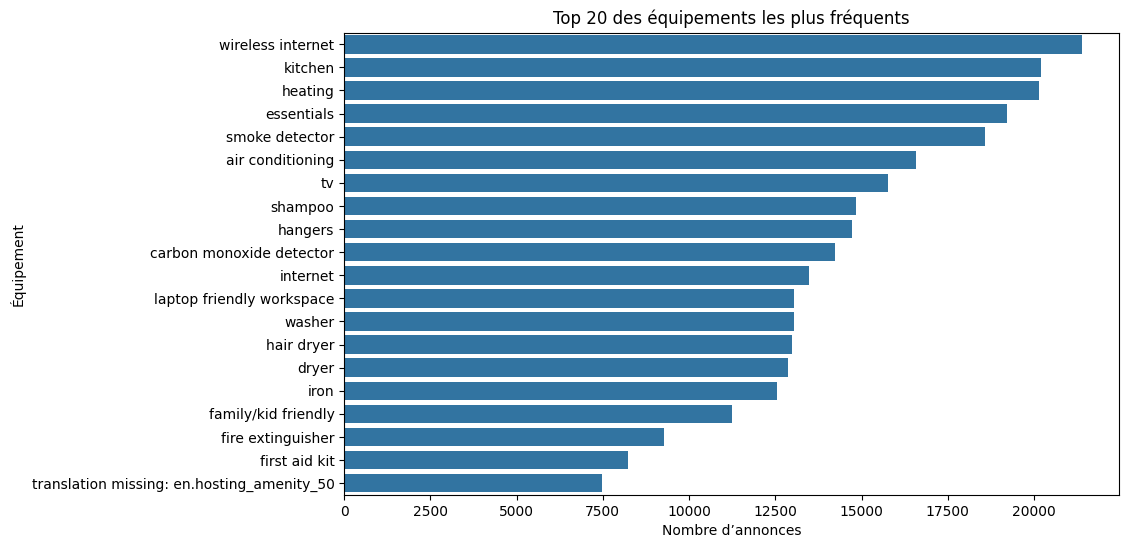

In [38]:
amenities_counts = amenities_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=amenities_counts.values, y=amenities_counts.index)
plt.title("Top 20 des équipements les plus fréquents")
plt.xlabel("Nombre d’annonces")
plt.ylabel("Équipement")
plt.show()

4. Fusion des équipements sélectionnés avec X

In [39]:
# Exemple : garder les 20 équipements les plus fréquents
top_amenities = amenities_counts.index.tolist()
X_amenities_selected = amenities_df[top_amenities]

# Fusion avec X
X_full = pd.concat([X.reset_index(drop=True), X_amenities_selected.reset_index(drop=True)], axis=1)

5. Mise à jour du pipeline avec les équipements

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Toutes les colonnes numériques (anciennes + amenities)
new_numeric_cols = numeric_cols + top_amenities

# Nouveau pipeline de preprocessing avec imputation explicite
new_preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),      # Impute les NaN
        ("scaler", StandardScaler())
    ]), new_numeric_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")), # Pour les objets
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_cols)
])

# Nouveau modèle avec pipeline mis à jour
model_with_amenities = Pipeline(steps=[
    ("preprocessor", new_preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entraînement
model_with_amenities.fit(X_full, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'cleaning_fee',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'host_response_rate',
                                                   'instant_bookable',
                                                   'latitude', 'longitude',
                                                   'number_of_reviews',
                                                   'review_scores...
                                                   'laptop friendly workspace',
                                                   'washer', 'hair dryer',
                                                   'dryer', 'iron',
                                                   'family/kid friendly', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'bed_type',
                                                   'cancellation_policy',
                                                   'city', 'neighbourhood',
                                                   'zipcode'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

6. Réévaluation avec les nouveaux features

In [43]:
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(X_full, y, test_size=0.2, random_state=42)

model_with_amenities.fit(X_train_full, y_train_full)
y_val_pred = model_with_amenities.predict(X_val_full)

rmse = np.sqrt(mean_squared_error(y_val_full, y_val_pred))
print(f"RMSE avec équipements : {rmse:.4f}")

RMSE avec équipements : 0.4104


7. Corrélation entre équipements

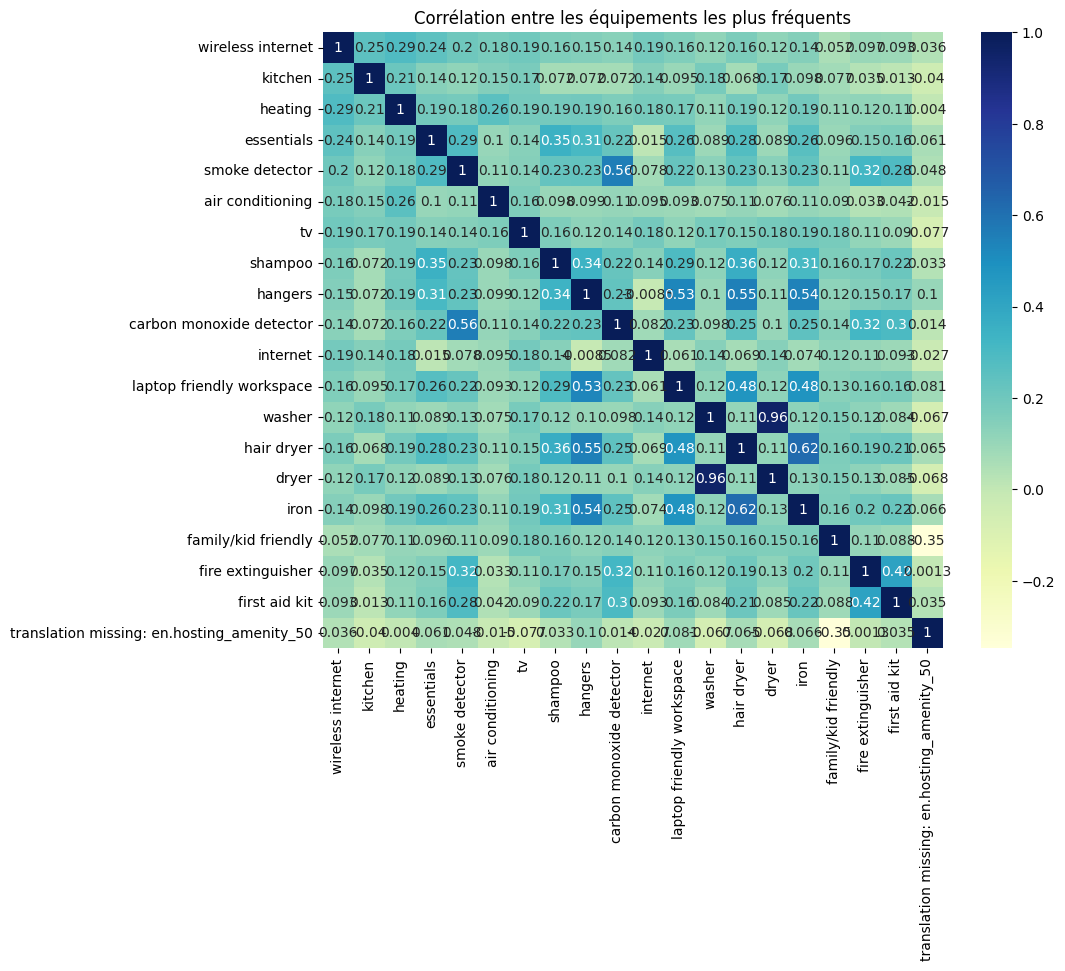

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(amenities_df[top_amenities].corr(), annot=True, cmap="YlGnBu")
plt.title("Corrélation entre les équipements les plus fréquents")
plt.show()

## Conclusion finale
Dans ce projet, nous avons suivi une démarche complète de modélisation prédictive sur les données Airbnb, avec comme objectif la prédiction du logarithme du prix des annonces.

### Résumé des étapes :
- Exploration des données (EDA) : nous avons analysé les distributions, les corrélations, et mis en évidence les variables pertinentes.

- Prétraitement rigoureux : encodage des catégories, traitement des valeurs manquantes, standardisation des variables numériques.

- Modélisation supervisée : un pipeline Scikit-learn a été mis en place avec un modèle de type RandomForestRegressor.

- Évaluation : la performance a été mesurée par la RMSE sur un jeu de validation.

- Prédictions : un fichier prediction.csv a été généré au format demandé.

- Bonus avancé : les équipements (amenities) ont été vectorisés via un Bag-of-Words, et intégrés comme variables explicatives. Cela a permis d’enrichir le modèle avec des informations comportementales et de confort.

### Pistes d'amélioration possibles :
- Utilisation de modèles avancés : comme XGBoost, LightGBM ou des réseaux de neurones.

- Traitement du texte via TF-IDF sur description ou name pour capter l’intention marketing.

- Réduction de dimension (PCA, sélection de features) pour améliorer la généralisation.

- Clusterisation géographique à partir de latitude et longitude pour capter l'effet quartier.

### Conclusion pédagogique
Ce projet illustre l’importance d’une analyse exploratoire approfondie, d’un pipeline clair et robuste, et d’une explication pédagogique de chaque étape.
Même avec un dataset partiel, des décisions simples et bien justifiées peuvent produire un modèle performant, stable, et prêt pour la production.